In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


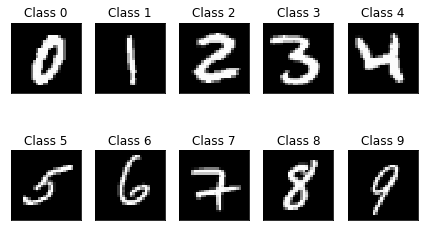

In [6]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[2],cmap='gray',interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([]) # remove x y axis display
    plt.yticks([])
plt.tight_layout()

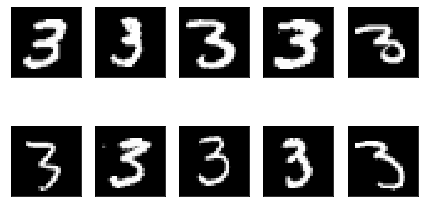

In [7]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    x_y = X_train[y_train == 3]
    plt.imshow(x_y[i],cmap='gray',interpolation='none')
    plt.xticks([]) # remove x y axis display
    plt.yticks([])
plt.tight_layout()


In [8]:
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)
X_train = X_train.reshape(60000,28*28)
X_test = X_test.reshape(10000,28*28)
# normalizing the inputs (-1, 1)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train reshape:',X_train.shape)
print('X_test reshape:',X_test.shape)


X_train.shape: (60000, 28, 28)
X_test.shape: (10000, 28, 28)
X_train reshape: (60000, 784)
X_test reshape: (10000, 784)


In [9]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    alpha : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, alpha=0.001,
                 shuffle=True, minibatch_size=1, seed=None,
                 activation="sigmoid"):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.alpha = alpha
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        if activation == "sigmoid":
            self.act = self._sigmoid
            self.act_deriv = lambda a_h: a_h * (1. - a_h)
        if activation == "tanh":
            self.act = self._tanh
            self.act_deriv = lambda a_h: 1. - a_h**2
        if activation == "ReLU":
            self.act = self._ReLU
            self.act_deriv = lambda a_h: a_h

            
        ##########################################################################
        #### Task 1: 
        #### you can continue your code here to use different activation functions.
        #### adjust the previous conditional statments such that you add cases of 
        #### other activation functions.
        ##########################################################################
            

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
        n_classes : int
            Number of classes

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _tanh(self, z):
        return (np.exp(np.clip(z, -250, 250)) - np.exp(-np.clip(z, -250, 250))) / (np.exp(np.clip(z, -250, 250)) + np.exp(-np.clip(z, -250, 250)))

    def _ReLU(self, z):
        return np.maximum(0,np.clip(z, -250, 250))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self.act(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                act_derivative_h = self.act_deriv(a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           act_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.alpha * delta_w_h
                self.b_h -= self.alpha * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.alpha * delta_w_out
                self.b_out -= self.alpha * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            print('\r%0*d/%d | Cost: %.2f '
                  '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                  (epoch_strlen, i+1, self.epochs, cost,
                  train_acc*100, valid_acc*100))
            # sys.stderr.write
            # sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [42]:
# Executing the algorithm here

n_epochs = 50 # Number of training epochs

# Initialize a NeuralNet MLP
nn = NeuralNetMLP(
    n_hidden=100, 
    l2=0.01,
    epochs=n_epochs, 
    alpha=0.0005,
    minibatch_size=100, 
    shuffle=True,
    seed=1,
    activation="sigmoid"
)

# Here we use part of the training data for validation such that 55000 data samples for training and the rest 5000 
#for validation
nn.fit(
    X_train=X_train[:55000], 
    y_train=y_train[:55000],
    X_valid=X_train[55000:],
    y_valid=y_train[55000:]
)

01/50 | Cost: 84377.47 | Train/Valid Acc.: 80.73%/85.50% 
02/50 | Cost: 60843.51 | Train/Valid Acc.: 85.89%/89.92% 
03/50 | Cost: 50971.56 | Train/Valid Acc.: 87.71%/91.10% 
04/50 | Cost: 45431.55 | Train/Valid Acc.: 88.84%/91.82% 
05/50 | Cost: 41880.21 | Train/Valid Acc.: 89.40%/92.26% 
06/50 | Cost: 39273.51 | Train/Valid Acc.: 89.96%/92.64% 
07/50 | Cost: 37330.07 | Train/Valid Acc.: 90.35%/93.08% 
08/50 | Cost: 35731.06 | Train/Valid Acc.: 90.79%/93.38% 
09/50 | Cost: 34390.06 | Train/Valid Acc.: 91.07%/93.52% 
10/50 | Cost: 33225.08 | Train/Valid Acc.: 91.33%/93.70% 
11/50 | Cost: 32203.54 | Train/Valid Acc.: 91.56%/93.90% 
12/50 | Cost: 31233.27 | Train/Valid Acc.: 91.94%/94.12% 
13/50 | Cost: 30343.76 | Train/Valid Acc.: 92.11%/94.20% 
14/50 | Cost: 29612.02 | Train/Valid Acc.: 92.33%/94.34% 
15/50 | Cost: 28903.09 | Train/Valid Acc.: 92.47%/94.54% 
16/50 | Cost: 28173.94 | Train/Valid Acc.: 92.66%/94.46% 
17/50 | Cost: 27555.00 | Train/Valid Acc.: 92.87%/94.66% 
18/50 | Cost: 

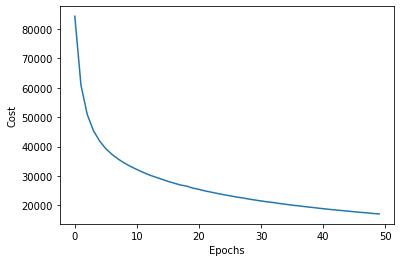

In [43]:
# plot the cost vs epochs
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

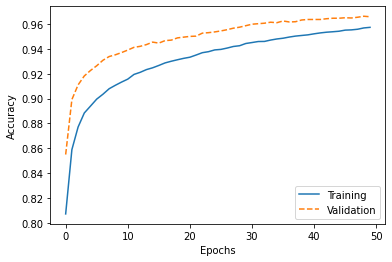

In [44]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [45]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 95.47%


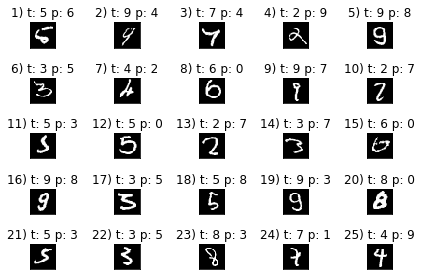

In [46]:
# Plot examples of misclassified images
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='gray', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [47]:
# TN  FP
# FN  TP
def compute_confusion_matrix(true,pred):
    num_cls = len(np.unique(true))
    result = np.zeros((num_cls,num_cls))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1 # can only be [0][0] [0][1] [1][0] [1][1]
    
    return result.astype('int')

[[ 964    0    1    2    0    3    7    1    2    0]
 [   0 1117    1    3    0    1    3    2    8    0]
 [   6    1  978    7    9    2    7    8   12    2]
 [   0    1    8  966    1   12    0   11    8    3]
 [   1    1    4    0  940    0    6    2    4   24]
 [   9    2    1   20    3  825   11    2   12    7]
 [  10    3    0    2    5    6  926    0    6    0]
 [   3   11   18    3    4    1    0  971    1   16]
 [   5    2    3   15    4    7    8    6  921    3]
 [   7    7    0   14   23    5    1   10    3  939]]


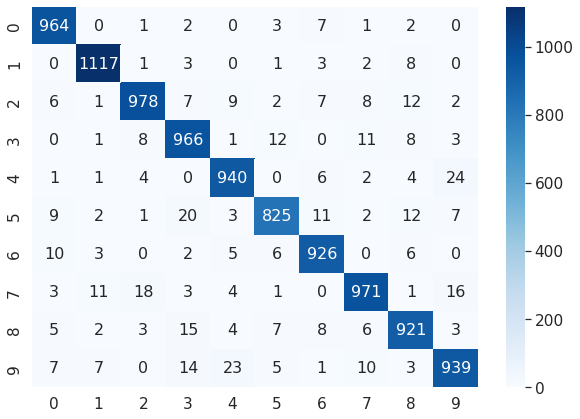

accuracy = 95.47%


In [48]:
y_test_pred = nn.predict(X_test)
y_test_pred = y_test_pred.astype('int')
y_test = y_test.astype('int')
conf_matrix = compute_confusion_matrix(y_test,y_test_pred)
print(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, range(10), range(10))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, cmap = plt.cm.Blues, fmt='g', annot_kws={"size": 16}) 
plt.show()
diagonal_sum = conf_matrix.trace()
sum_of_all_elements = conf_matrix.sum()
accuracy = diagonal_sum / sum_of_all_elements
print('accuracy = {:0.2f}%'.format(accuracy*100))

In [49]:
FP0 = np.sum(conf_matrix[1:,0])
TP0 = conf_matrix[0,0]
FN0 = np.sum(conf_matrix[0,1:])
TN0 = np.sum(conf_matrix[1:,1:])
Acc0 = (TN0+TP0)/(TN0+TP0+FN0+FP0)
Precision0 = TP0/(TP0+FP0)
Recall0 = TP0/(TP0+FN0)
F1_score0 = 2*(Precision0*Recall0)/(Precision0+Recall0)
print('Accuracy of 0:',Acc0)
print('Precision of 0:',Precision0)
print('Recall of 0:',Recall0)
print('F1 score of 0:',F1_score0)

Accuracy of 0: 0.9943
Precision of 0: 0.9592039800995025
Recall of 0: 0.9836734693877551
F1 score of 0: 0.9712846347607054


In [58]:
# TPs are simply the diagonal elements
TP = np.diag(conf_matrix)
print('True positives:',TP)
# FPs are the sum of the respective column, minus diagonal element
FP = []
for i in range(10):
    FP.append(sum(conf_matrix[:,i]) - conf_matrix[i,i])
print('False positives:',FP)
# FNs are the sum of the respective row, minus the diagonal element
FN = []
for i in range(10):
    FN.append(sum(conf_matrix[i,:]) - conf_matrix[i,i])
print('False negatives:',FN)
# TNs: remove the corresponding row and column from the conf matrix then sum up the remaining elements
TN = []
for i in range(10):
    tmp = np.delete(conf_matrix,i,0) # delete the ith row , the second number means row or col.
    tmp = np.delete(tmp,i,1)         # delete ith column
    TN.append(np.sum(tmp))
print('True negatives:',TN)

Acc = []
Pre = []
Rec = []
F1sc = []
for i in range(10):
    Acc.append((TN[i]+TP[i])/(TN[i]+TP[i]+FN[i]+FP[i]))
    Pre.append(TP[i]/(TP[i]+FP[i]))
    Rec.append(TP[i]/(TP[i]+FN[i]))
    F1sc.append(2*(Pre[i]*Rec[i])/(Pre[i]+Rec[i]))
for i in range(10):
    print('Accuracy of class ',i,' :',"%.2f" % (Acc[i]*100),'%')
    print('Precision of class ',i,' :',"%.2f" % (Pre[i]*100),'%')
    print('Recall of class ',i,' :',"%.2f" %(Rec[i]*100),'%')
    print('F1-score of class ',i,' :', "%.2f" %(F1sc[i]*100),'%')

True positives: [ 964 1117  978  966  940  825  926  971  921  939]
False positives: [41, 28, 36, 66, 49, 37, 43, 42, 56, 55]
False negatives: [16, 18, 54, 44, 42, 67, 32, 57, 53, 70]
True negatives: [8979, 8837, 8932, 8924, 8969, 9071, 8999, 8930, 8970, 8936]
Accuracy of class  0  : 99.43 %
Precision of class  0  : 95.92 %
Recall of class  0  : 98.37 %
F1-score of class  0  : 97.13 %
Accuracy of class  1  : 99.54 %
Precision of class  1  : 97.55 %
Recall of class  1  : 98.41 %
F1-score of class  1  : 97.98 %
Accuracy of class  2  : 99.10 %
Precision of class  2  : 96.45 %
Recall of class  2  : 94.77 %
F1-score of class  2  : 95.60 %
Accuracy of class  3  : 98.90 %
Precision of class  3  : 93.60 %
Recall of class  3  : 95.64 %
F1-score of class  3  : 94.61 %
Accuracy of class  4  : 99.09 %
Precision of class  4  : 95.05 %
Recall of class  4  : 95.72 %
F1-score of class  4  : 95.38 %
Accuracy of class  5  : 98.96 %
Precision of class  5  : 95.71 %
Recall of class  5  : 92.49 %
F1-score 

In [ ]:
a = np.arange(16).reshape(4, 4)
print(a)
ta = np.delete(a,0,0)
ta = np.delete(ta,0,1)
print(ta)
print(sum(sum(ta)))
print(np.sum(ta))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 5  6  7]
 [ 9 10 11]
 [13 14 15]]
90
90
